In [1]:
using Pkg
Pkg.activate(".")
Pkg.add("Plots")
Pkg.add("Flux")
Pkg.add("LaTeXStrings")
Pkg.add("Zygote")

using Flux
using Plots
using LaTeXStrings
using Zygote

 Activating environment at `~/Documents/daviddewhurst.github.io/teaching/cs387/notes/Project.toml`
   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/Documents/daviddewhurst.github.io/teaching/cs387/notes/Project.toml`
No Changes to `~/Documents/daviddewhurst.github.io/teaching/cs387/notes/Manifest.toml`
  Resolving package versions...
No Changes to `~/Documents/daviddewhurst.github.io/teaching/cs387/notes/Project.toml`
No Changes to `~/Documents/daviddewhurst.github.io/teaching/cs387/notes/Manifest.toml`
  Resolving package versions...
No Changes to `~/Documents/daviddewhurst.github.io/teaching/cs387/notes/Project.toml`
No Changes to `~/Documents/daviddewhurst.github.io/teaching/cs387/notes/Manifest.toml`
  Resolving package versions...
No Changes to `~/Documents/daviddewhurst.github.io/teaching/cs387/notes/Project.toml`
No Changes to `~/Documents/daviddewhurst.github.io/teaching/cs387/notes/Manifest.toml`


## Optimization review

+ By optimization I mean continuous optimization (and probably differentiable, at least weakly) -- our functions look like 
$f: \mathbb R^N \rightarrow \mathbb R$ or something similar, and we assume that $f'$ exists in either the strong or weak sense. 
+ "Weak sense": we say $f'$ is a weak derivative of the continuous function $f$ if $\int_{\mathbb R} dx\ f'(x) g(x) = - \int_{\mathbb{R}} dx\ g'(x) f(x)$ for all $g(x)$ satisfying $\lim_{x \rightarrow \pm \infty} g(x) = 0$. 
    + E.g., $\Theta(x) = \begin{cases} 1\ \text{if } x > 0\\ 0\ \text{otherwise} \end{cases}$ has a weak derivative at $x=0$ given by [delta function](https://en.wikipedia.org/wiki/Dirac_delta_function)
    + identical in higher dims except with gradient (see below) 
+ We know how to optimize (say minimize) twice-differentiable functions of a single variable: take derivative, set equal to zero, solve, check $d^2 f/dx^2 > 0$ near the critical point $x^*$. 

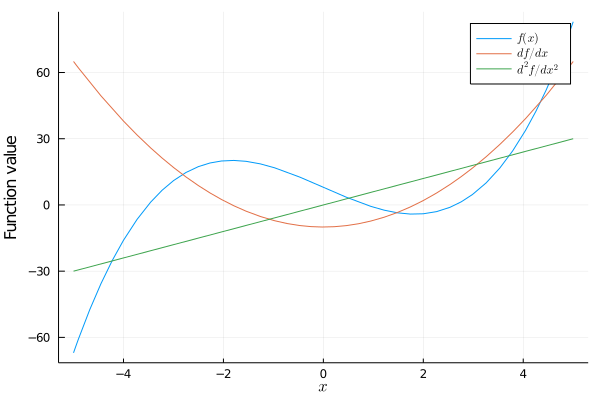

In [2]:
f(x) = x^3 - 10x + 8
df(x) = gradient(f, x)[1]  # "gradient" (see below) is just first derivative here
d2f(x) = gradient(df, x)[1]  # how does this magic work? You will learn... kind of...

p = plot()
plot!(p, f, label=L"f(x)")
plot!(p, df, label=L"df/dx")
plot!(p, d2f, label=L"d^2f/dx^2", xlabel=L"x", ylabel="Function value")

+ In higher dimensions $f:\mathbb R^N \mapsto \mathbb R$ things are similar
    + Now take *gradient* $f(x) \mapsto \nabla f(x)$, where
        $$
        \nabla f(x) = \sum_{i=1}^N \partial_i f(x) {\bf e_i}
        $$
        i.e. 
        $$
        \nabla f(x) = 
        \begin{pmatrix}
        \partial_1 f(x) \\ 
        \vdots \\
        \partial_N f(x)
        \end{pmatrix}
        $$
    + Checking "second derivatives" means now checking that the Hessian is positive definite. Hessian matrix:
        $$
        {\bf H}[f] = 
        \begin{pmatrix}
            \partial^2_1 f & \partial^2_{1,2}f & \cdots & \partial^2_{1,N}f\\
            \vdots & \vdots & \ddots & \vdots \\
            \partial^2_{N.1} f & \partial^2_{N,2}f & \cdots & \partial^2_Nf
        \end{pmatrix}
        $$
        Positive definite: $y^\dagger {\bf H}f y > 0$ for all $y \in \mathbb R^N$. This is usually very hard to verify and we don't bother with this in practice ¯\\_(ツ)_/¯. 
        + (Notable exception: 1-1 correspondence between positive definite matrices and covariance matrices of non-degenerate multivariate pdfs; we will return to this later in the course)

In [3]:
# confusingly for us, Julia is column major
# to follow along with our "math" notation just transpose stuff
# Fortran is also column major, while python / C ... are row major
# see https://www.reddit.com/r/Julia/comments/gru996/julias_worst_but_possibly_only_mistake/ 
N = 3
M = 2
W = randn(N, M)
b = randn(N)

g(x) = sum(W*x + b)
dg(x) = gradient(g, x)[1]

cute_vector = [1.0, 2.0]
grad_g_cute_vector = dg(cute_vector)
println("At x = $cute_vector, grad_g = $grad_g_cute_vector")

At x = [1.0, 2.0], grad_g = [2.503294214185675, -4.2769730440132285]


+ With $f:\mathbb R^N \mapsto \mathbb R^M$ things get more fun. Time for [matrix calculus](https://en.wikipedia.org/wiki/Matrix_calculus) and the Jacobian matrix (still write as $\partial_x f$ but also ${\bf J}f$):
    $$
    \partial_x f(x) = 
    \begin{pmatrix}
    \partial_1 f_1 & \cdots & \partial_N f_1 \\
    \vdots & \ddots & \vdots \\ 
    \partial_1 f_M & \cdots & \partial_N f_M
    \end{pmatrix}
    $$
+ Recall chain rule from ordinary calculus: suppose $y = f_n\circ f_{n-1} \circ \cdots \circ f_1$. Taking derivatives, we have
    $$
    \frac{dy}{dx} = \frac{dy}{df_{n-1}}\frac{df_{n-1}}{df_{n-2}}
    \cdots
    \frac{df_1}{dx}
    $$
+ This works fine in higher dimensions also, but now the intermediate derivatives $df_i/df_{i+1}$ are Jacobians because in general the domain / codomain dimensions of each $f_i$ aren't equal (as long as they match correctly):
    $$
    \partial_x y = \partial_{f_{n-1}}y\ \partial_{f_{n-2}}f_{n-1}
    \cdots
    \partial_{x}f_1
    $$
+ In "math" we usually don't think about how to do this -- but these are matrices so multiplication isn't commutative. Time for us to think about *in what order to compute*. Many ways to do this -- we talk about "forward" and "backward":
    + *Forward*
        $$
        \begin{aligned}
        \partial_x y &= \partial_{f_{n-1}}y\ \partial_{x}f_{n-1} \\
        &= \partial_{f_{n-1}}y\ (\partial_{f_{n-2}}f_{n-1}\ \partial_{x}f_{n-2}) \\
        &\vdots
        \end{aligned}
        $$
        When we were in calculus, this is the way most of us did it. 
    + *Backward*
        $$
        \begin{aligned}
        \partial_x y &= \partial_{f_1}y\ \partial_{x}f_{1} \\
        &= (\partial_{f_{2}}y\ \partial_{f_{1}}f_{2})\ \partial_{x}f_{1} \\
        &\vdots
        \end{aligned}
        $$
+ Now you know about [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (please read the wikipedia page). The core concept here (at least, core to being able to implement differentiation and hence continuous optimization on the computer) is the *pullback* which allows for automated application of the chain rule. If $y = f(x)$, write $\partial_y u = \bar y$. The pullback is a vector functional 
    $$
    f \mapsto \bar y\ \partial_x f.
    $$
    *WHY?* Because this allows for automated *reverse* differentiation. We've calculated one derivative, $\partial_x f$, and we're ready to substitute another derivative (gradient) in for $\bar y$.
+ Please read the [Zygote](https://fluxml.ai/Zygote.jl/latest/) documentation to learn more about this.

In [4]:
row_dim = 4
col_dim = 1

# logistic regression
# using Flux constructs - don't worry for now, this is just a logistic regression model
# conveniently using some built-in structs / functions
model = Dense(row_dim, col_dim, σ)
model2 = Dense(row_dim, col_dim, σ)

function bce_loss(y_true, y_pred)
    neg_loss = y_true .* log.(y_pred) .+ (1.0 .- y_true) .* log.(1.0 .- y_pred)
    sum(-1.0 * neg_loss)
end

n_datapoints = 10
random_input_data = randn(row_dim, n_datapoints)
y_pred = model(random_input_data)
y_true = model2(random_input_data)

vals, back = pullback(bce_loss, y_pred, y_true);

Evaluating `back` at `1` sets $\bar y = 1$ and hence gives us our gradient:

In [5]:
grads = back(1)
# should be a function of *two variables* -- y_pred and y_true
@assert length(grads) == 2
for i in 1:length(grads)
    @assert size(grads[i]) == (1, n_datapoints)
end

# check 'em
grads

([1.1432082845316884 -0.8681119247970202 … -0.09228051891459332 0.6395691294560546], [1.291869253528375 1.4815231710164647 … 1.0379191081405685 -1.3188832399902624])

+ Constrained optimization in continuous space isn't so much more tricky. The key is to make the optimization first unconstrained, solve as normal, and then either a) solve for the constraints or b) don't really care, because the point was penalizing your objective function anyway...(c.f. regularization from DS1). Theory: [Karush-Kuhn-Tucker](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions) (wikipedia or your favorite mathematical optimization / economics text).
+ Problem setup is often something like 
    $$
    \min_x f(x) \text{ subject to } g_i(x) = G_i,\ i = 1,...,K
    $$
    with $f$ and each $g_i$ a scalar function.
    Introducing multipliers allows us to write an unconstrained problem that we know how to solve using all the tools described so far!
    $$
    J = f(x) + \sum_{i=1}^K \lambda_i g_i(x)
    $$
+ Now we can find a critical point of $J$ (hopefully a minimum, check Hessian or...come back next lesson...) just by taking grads and solve:
    $$
    \nabla J = \nabla f + \sum_{i=1}^K \lambda_i \nabla g_i = 0,
    $$
    which we already know how to do. 